# BigARTM

Topic modeling is a type of statistical modeling for discovering the abstract “topics” in a collection of documents. LDA (Latent Dirichlet Allocation) is one of the most popular and widely used tools for that. **BigARTM** is a tool to infer topic models, based on a novel technique called <em>**Additive Regularization of Topic Models**</em>. This technique effectively builds multi-objective models by adding the weighted sums of regularizers to the optimization criterion. BigARTM is known to combine well very different objectives, including sparsing, smoothing, topics decorrelation and many others. Such combinations of regularizers significantly improves several quality measures at once almost without any loss of the perplexity.

The pip installation for BigARTM is only available for linux, hence for this practical we will execute it using google colab. For windows installation you can refer to this guide: https://bigartm.readthedocs.io/en/stable/installation/windows.html

Install the following library:
> pip install bigartm

In [ ]:
"""
Run this command. This will clone/download the necessary jupyter notebook and data files required
"""

!git clone https://github.com/limaih/bigartm

## Import libraries and load dataset
For this practical we will use the NIPS papers. You can find the full dataset from kaggle: https://www.kaggle.com/datasets/benhamner/nips-papers?select=papers.csv

The practical below is built using NIPS papers in 2017. Try out using the full dataset. Upload the papers.csv file to colab session storage and change the codes below to use the full dataset.

~~~Python
import pandas as pd

df = pd.read_csv('bigartm/papers2017.csv')
all_texts = df['paper_text']
all_texts.head()
~~~

## Data Preprocessing
We will begin with data preprocessing with the following pipeline:
1. lowercase
2. remove punctuation
3. lemmatizing
4. remove stopwords
5. remove short words & digits

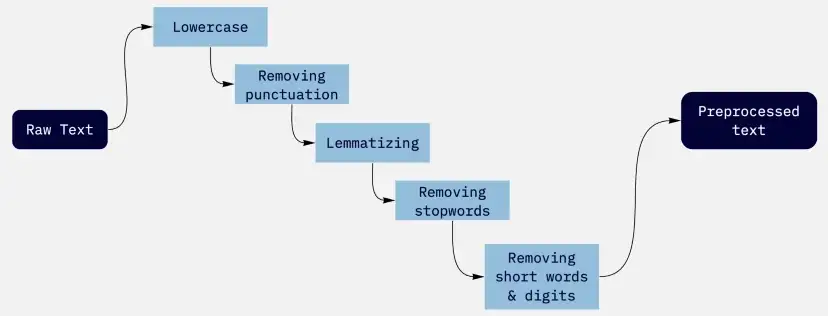

~~~Python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import word_tokenize

import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer=WordNetLemmatizer()

ps = PorterStemmer()
cachedStopWords = ["fig", "figure", "et", "al", "table", "data", "analysis", "analyze", "study", "method", "result", 
                   "conclusion", "author", "find", "found", "show", "perform", "demonstrate", "evaluate", "discuss", 
                   "google", "scholar", "pubmed", "web", "science", "crossref", "supplementary", "(fig.)", "(figure", 
                   "fig.", "al.", "did", "thus,", "…", "" "", "interestingly", "and/or", "author"] + list(esw)

def lemmatize_article(sentence):
    sentence = word_tokenize(sentence)
    res = ''
    for word in sentence:
        word = lemmatizer.lemmatize(word)
        res += word + ' '
    return res
    
def remove_stop_words(sentence):
    return ' '.join([word for word in sentence.split() if word not in cachedStopWords])
    
def remove_short(sentence):
    return ' '.join([word for word in sentence.split() if len(word) >= 3])
    
def remove_digits(sentence):
    return ' '.join([i for i in sentence.split() if not i.isdigit()])
    
def preprocess(all_texts):
    all_texts = list(map(lambda x: x.lower(), all_texts))
    all_texts = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), all_texts))
    all_texts = list(map(lambda x: lemmatize_article(x), all_texts))
    all_texts = list(map(lambda x: x.strip(), all_texts))
    all_texts = list(map(lambda x: remove_stop_words(x), all_texts))
    all_texts = list(map(lambda x: remove_short(x), all_texts))
    all_texts = list(map(lambda x: remove_digits(x), all_texts))
    return all_texts

all_texts = preprocess(all_texts)
all_texts[0]
~~~

## Extract ngrams
Now we are ready to tokenize the sentences, obtain a bag of words and perform topic modeling. n-grams are sometimes very useful for this purpose. They help to extract well-established expressions and understand each topic better. We’ll take ones that are the most frequent among the documents.

~~~Python
from collections import Counter
from nltk import ngrams

def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [' '.join(grams) for grams in n_grams]

bigrams = []
for article in all_texts:
    bigrams += list(map(lambda x: x[0], list(filter(lambda x: x[1] >= 5, 
                                                    Counter(get_ngrams(article, 2)).most_common()))))
    
bigrams = list(filter(lambda x: 'package' not in x and 'document' not in x, bigrams))
bigrams = list(map(lambda x: x[0], (list(filter(lambda x: x[1] >= 5, Counter(bigrams).most_common())))))

print(len(bigrams))
print(bigrams[:5])
~~~

## ARTM model
All preprocessing has been done so we can move to our model. To do this, we have to create a matrix with words over documents which the model uses as an input.

~~~Python
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

n_wd_bigrams = np.empty((len(bigrams), len(all_texts)))

for i in range(len(bigrams)):
    for j in range(len(all_texts)):
        n_wd_bigrams[i][j] = all_texts[j].count(bigrams[i])
        
cv = CountVectorizer(max_features = 1000, stop_words='english')
n_wd = np.array(cv.fit_transform(all_texts).todense()).T
vocabulary = cv.get_feature_names()

n_wd = np.concatenate((n_wd, n_wd_bigrams))
vocabulary += bigrams
~~~

ARTM library provides you with a huge functionality to affect the learning process. It allows adding various regularizers to control the learning process and to change phi and theta matrices to be more sparse, for example. In a top level model I added a sparsity regularizer for theta matrix and decorrelator which stimulates phi sparsity.

Besides, we can specify metrics that we want to use for evaluation (Here there are Perxplexity and matrices sparstities). We add these regularizers to make topics more interpretable but we have to do that carefully with only a slight decrease of perplexity.

~~~Python
import artm

bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=vocabulary)
dictionary = bv.dictionary
topic_names = ['topic_{}'.format(i) for i in range(10)]

model_artm = artm.ARTM(topic_names = topic_names, cache_theta=True, 
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary), 
                               artm.SparsityPhiScore(name='SparsityPhiScore'),
                               artm.SparsityThetaScore(name='SparsityThetaScore'),
                               artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3), 
                               artm.TopTokensScore(name='TopTokensScore', num_tokens=8)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.4),
                                     artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)])
                                     
model_artm.num_document_passes = 4
model_artm.initialize(dictionary)
model_artm.fit_offline(batch_vectorizer=bv, num_collection_passes=20)
~~~

## Model Quality
The ARTM model quality is assessed using the following measures:
1. **Perplexity**: This is inversely proportional to the likelihood of the data given the model. The smaller the perplexity the better the model.
2. **Sparsity**: This measures the percentage of elements that are zero in the ∅ and θ matrices.
3. **Ratio of background words**: A high ratio of background words indicates model degradation and is a good stopping criterion. This could be due to too much sparsing or elimination of topics.
4. **Coherence**: This is used to measure the interpretability of a model. A topic is supposed to be coherent, if the most frequent words in a topic tend to appear together in the documents.
5. **Kernel size, purity and contrast**: A kernel is defined as the subset of words in a topic that separates a topic from the others. For a topic model, higher values are better for both purity and contrast.


Let's look at the main measures:

~~~Python
import matplotlib.pyplot as plt

def print_measures(model_artm):
    print('Sparsity Phi ARTM:{}'.format(model_artm.score_tracker['SparsityPhiScore'].last_value))
    print('Sparsity Theta ARTM:{}'.format(model_artm.score_tracker['SparsityThetaScore'].last_value))
    print('Perplexity ARTM: {}'.format(model_artm.score_tracker['PerplexityScore'].last_value))
    
    fig, axs = plt.subplots(1, 3, figsize = (30, 5))
    
    for idx, score, y_label in zip(range(3), ['PerplexityScore', 'SparsityPhiScore', 'SparsityThetaScore'], 
                                             ['ARTM perplexity', 'ARTM Phi sparsity', 'ARTM Theta sparsity']):
        axs[idx].plot(range(model_artm.num_phi_updates), model_artm.score_tracker[score].value, 'r--', linewidth=2)
        axs[idx].set_xlabel('Iterations count')
        axs[idx].set_ylabel(y_label)
        axs[idx].grid(True)
        
print_measures(model_artm)
~~~

Let's look at the topics that we have obtained:

~~~Python
for topic_name in model_artm.topic_names: 
    print(topic_name + ': ' +  str(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]))
~~~

## Building hierarchy
The topics that we have got seem rather vague, although we can see differences between them. If we are interested in a particular topic, we might want to look at the subtopics of this one and to narrow down the search area. For such purposes, we can build a hierarchy of models that looks like a tree. We will use only one additional level with 50 topics.
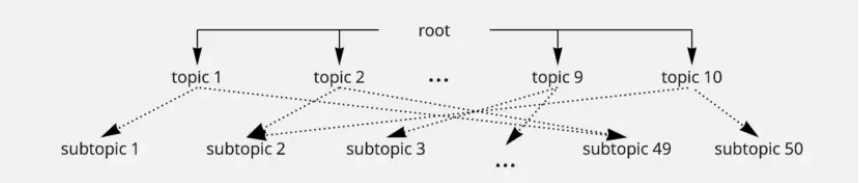

~~~Python
topic_names = ['topic_{}'.format(i) for i in range(20)]

model_artm1 = artm.ARTM(topic_names=topic_names,cache_theta=True, 
                        scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary), 
                                artm.SparsityPhiScore(name='SparsityPhiScore'),
                                artm.SparsityThetaScore(name='SparsityThetaScore'), 
                                artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3),
                                artm.TopTokensScore(name='TopTokensScore',num_tokens=12)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.4),
                        artm.SmoothSparsePhiRegularizer(name='SparsePhi',tau=-0.25),
                        artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)], seed=243) #seed is required for heirarchy 
                        
model_artm1.num_document_passes = 4
model_artm1.set_parent_model(parent_model = model_artm, parent_model_weight = 0.75)
model_artm1.initialize(dictionary)

model_artm1.fit_offline(batch_vectorizer=bv, num_collection_passes=12)

subt = pd.DataFrame(model_artm1.get_parent_psi())
subt.columns = ['topic_{}'.format(i) for i in range(10)]
subt.index = ['subtopic_{}'.format(i) for i in range(20)]
subt.head()
~~~

Let's look at the words in the subtopics:

~~~Python
for topic_name in model_artm1.topic_names: 
    print(topic_name + ': ' +  str(model_artm1.score_tracker['TopTokensScore'].last_tokens[topic_name]))
~~~